In [79]:
# ---------------------------------------------------------------
#  CREDIT CARD FRAUD DETECTION USING AUTOENCODER (ANOMALY DETECTION)
# ---------------------------------------------------------------
# Objective:
# Build an Autoencoder model that learns to reconstruct normal (non-fraudulent)
# credit card transactions, and use reconstruction error to detect anomalies.
# ---------------------------------------------------------------

# ✅ STEP 1: IMPORT REQUIRED LIBRARIES
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# ---------------------------------------------------------------
# ✅ STEP 2: LOAD AND PREPARE THE DATA
# ---------------------------------------------------------------

# File path to the dataset (change if needed)
FILE_PATH = "/Users/prathamesh/Downloads/creditcard.csv"

# Load dataset
df = pd.read_csv(FILE_PATH)
print("✅ Dataset loaded successfully!")
print("Shape of dataset:", df.shape)

# Separate input features (X) and target variable (y)
X = df.drop(['Time', 'Class'], axis=1)  # Drop 'Time' and 'Class' columns
y = df['Class']                         # Target column (0 = Normal, 1 = Fraud)

# ---------------------------------------------------------------
# ✅ STEP 3: SCALE THE FEATURES
# ---------------------------------------------------------------

# Neural networks train better when all inputs are on a similar scale.
# Without scaling, large values (like “Amount”) can dominate smaller ones (like V1).


# Standardize features for efficient neural network training
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine number of features
INPUT_DIM = X_scaled.shape[1]  # (29 features: V1–V28 + Amount)
print(f"\nInput dimension: {INPUT_DIM} features")

# ---------------------------------------------------------------
# ✅ STEP 4: PREPARE NORMAL TRANSACTIONS FOR TRAINING
# ---------------------------------------------------------------

# Train the Autoencoder only on NORMAL transactions (Class = 0)
X_normal = X_scaled[y == 0]

# Split normal transactions into training and validation sets
X_train_normal, X_val_normal = train_test_split(
    X_normal, test_size=0.2, random_state=42
)

print(f"Training Autoencoder on {X_train_normal.shape[0]} normal transactions.")
print(f"Validation set: {X_val_normal.shape[0]} normal transactions.")

✅ Dataset loaded successfully!
Shape of dataset: (284807, 31)

Input dimension: 29 features
Training Autoencoder on 227452 normal transactions.
Validation set: 56863 normal transactions.


| Step             | What Happens                                             |
| ---------------- | -------------------------------------------------------- |
| **1. Input**     | We feed normal transactions (numbers)                    |
| **2. Encoder**   | Learns to compress and represent normal data efficiently |
| **3. Decoder**   | Learns to rebuild it back                                |
| **4. Training**  | Learns to minimize reconstruction loss                   |
| **5. Testing**   | When fraud data comes in, reconstruction error shoots up |
| **6. Threshold** | Errors above threshold → marked as fraud                 |


| Concept                    | Meaning                                             |
| -------------------------- | --------------------------------------------------- |
| **Autoencoder**            | Neural network that learns to reconstruct its input |
| **Encoder**                | Compresses input into smaller latent space          |
| **Decoder**                | Reconstructs input from latent representation       |
| **Training**               | Minimizes difference between input and output       |
| **Use in Fraud Detection** | Trained only on normal data → high error for frauds |
| **Output Metric**          | Reconstruction Error (MSE)                          |
| **Decision Rule**          | If error > threshold → Fraud                        |



In [91]:

# ---------------------------------------------------------------
# ✅ STEP 5: DEFINE THE AUTOENCODER ARCHITECTURE
# ---------------------------------------------------------------

# Dimensionality parameters
INTERMEDIATE_DIM = 24   # Hidden layer dimension
LATENT_DIM = 14         # Bottleneck dimension (compressed representation)

# # Input Layer
# input_layer = Input(shape=(INPUT_DIM,), name="Input_Layer")

# # Encoder
# encoded = Dense(INTERMEDIATE_DIM, activation="relu", name="Encoder_L1")(input_layer)
# latent_layer = Dense(LATENT_DIM, activation="relu", name="Latent_Representation")(encoded)

# # Decoder (Symmetrical to Encoder)
# decoded = Dense(INTERMEDIATE_DIM, activation="relu", name="Decoder_L1")(latent_layer)
# output_layer = Dense(INPUT_DIM, activation="linear", name="Output_Reconstruction")(decoded)

# autoencoder = Model(inputs=input_layer, outputs=output_layer)

autoencoder = Sequential([
    Input(shape=(INPUT_DIM,)),
    Dense(INTERMEDIATE_DIM, activation='relu'),
    Dense(LATENT_DIM, activation='relu'),
    Dense(INTERMEDIATE_DIM, activation='relu'),
    Dense(INPUT_DIM, activation='linear')
], name='Autoencoder_Model')


# Build the full Autoencoder model

# This line connects all the layers you defined (encoder → decoder).
# It tells Keras:
# “When I give you an input (29 features), pass it through all layers until you get the output (29 reconstructed features).”


# ---------------------------------------------------------------
# ✅ STEP 6: COMPILE THE MODEL
# ---------------------------------------------------------------

# This prepares the model for training.

# optimizer=Adam(learning_rate=0.001)
# → Chooses how weights will be updated.
# Adam automatically adjusts learning rates for faster, stable training.

# loss='mse'
# → “Mean Squared Error” = average squared difference between original input X and reconstructed output X_hat.
# Model tries to minimize this — i.e., make reconstruction as close to original as possible.

# metrics=['mse']
# → Just for monitoring — prints MSE at every epoch (so you can see how training improves).

autoencoder.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',          # Mean Squared Error measures reconstruction quality
    metrics=['mse']
)

# Display model summary
autoencoder.summary()

Model: "Autoencoder_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_38 (Dense)                │ (None, 24)             │           720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 14)             │           350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 24)             │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 29)             │           725 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,155 (8.42 KB)

 Trainable params: 2,155 (8.42 KB)

 Non-trainable params: 0 (0.00 B)

In [92]:

# ---------------------------------------------------------------
# ✅ STEP 7: TRAIN THE AUTOENCODER
# ---------------------------------------------------------------

print("\n🚀 Starting Autoencoder training...")

EPOCHS = 20
BATCH_SIZE = 128

history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_normal, X_val_normal),
    shuffle=True,
    verbose=1
)

print("\n✅ Autoencoder training complete!")


🚀 Starting Autoencoder training...
Epoch 1/20
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.4977 - mse: 0.4977 - val_loss: 0.3527 - val_mse: 0.3527
Epoch 2/20
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.2977 - mse: 0.2977 - val_loss: 0.2757 - val_mse: 0.2757
Epoch 3/20
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.2487 - mse: 0.2487 - val_loss: 0.2492 - val_mse: 0.2492
Epoch 4/20
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.2254 - mse: 0.2254 - val_loss: 0.2312 - val_mse: 0.2312
Epoch 5/20
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2113 - mse: 0.2113 - val_loss: 0.2221 - val_mse: 0.2221
Epoch 6/20
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.2053 - mse: 0.2053 - val_loss: 0.2184 - val_mse: 0.2184
Epoch 7/20
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.2024 - mse: 0.2024 - val_loss: 0.2194 - val_mse: 0.2194
Epoch 8/20
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1995 - mse: 0.1995 - val_loss: 0.2172 - val_mse: 0.2172
Epoc

8901/8901 ━━━━━━━━━━━━━━━━━━━━ 5s 565us/step
[[-6.98294222e-01 -7.62817934e-02  1.84077907e+00 ... -1.02866590e-01
   1.23612404e-01 -1.57277286e-01]
 [ 6.22868836e-01  1.22170836e-01 -1.89256668e-03 ... -1.60957798e-01
  -1.06882215e-01 -3.39375317e-01]
 [-7.52756059e-01 -9.07720447e-01  7.31279254e-01 ... -3.71118009e-01
  -5.31933188e-01  1.27881098e+00]
 ...
 [ 1.04338539e+00 -3.00518125e-01 -2.13319111e+00 ... -2.14293852e-01
  -1.95160151e-01 -1.47895008e-01]
 [-4.01125491e-01  2.11762160e-01  1.17305970e+00 ...  3.48147482e-01
   5.02590418e-01 -2.64293551e-01]
 [-4.47334349e-01 -3.93552557e-02  3.23991716e-01 ... -6.43171519e-02
   1.88519955e-01  5.26187301e-01]]
[[-0.69424232 -0.04407492  1.6727735  ...  0.33089162 -0.06378115
   0.24496426]
 [ 0.60849633  0.16117592  0.1097971  ... -0.02225568  0.04460752
  -0.34247454]
 [-0.69350046 -0.81157783  1.16946849 ... -0.13713686 -0.18102083
   1.16068593]
 ...
 [ 0.98002374 -0.18243372 -2.14320514 ...  0.01103672 -0.0804672
  -0.0

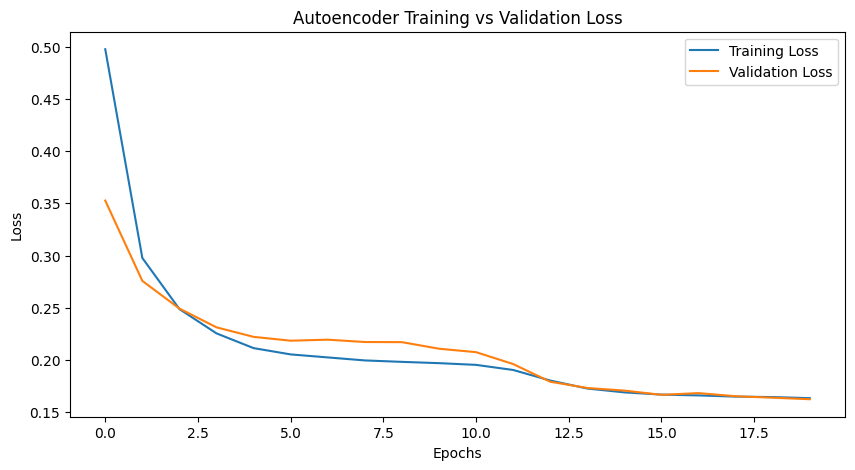

In [93]:
# ---------------------------------------------------------------
# ✅ STEP 8: CALCULATE RECONSTRUCTION ERRORS
# ---------------------------------------------------------------

# Reconstruct all transactions (both normal and fraudulent)
reconstructed_data = autoencoder.predict(X_scaled)
print(reconstructed_data)
print(X_scaled)

# Calculate reconstruction error (MSE) for each sample
reconstruction_error = np.mean(np.square(X_scaled - reconstructed_data), axis=1)

# Create a DataFrame with errors and true classes
error_df = pd.DataFrame({
    'Reconstruction_Error': reconstruction_error,
    'True_Class': y
})

print("\nSample Reconstruction Errors:")
print(error_df.head())

Normal_error  0         0.085187
1         0.041386
2         0.631024
3         0.225636
4         0.116469
            ...   
284802    3.994900
284803    0.296046
284804    0.058358
284805    0.509885
284806    0.054818
Name: Reconstruction_Error, Length: 284315, dtype: float64
Threshold  0.82320252051591

📊 Calculated Anomaly Detection Threshold: 0.823203

Confusion Matrix:
[[278628   5687]
 [   110    382]]

🔍 Precision: 6.29%
🔍 Recall:    77.64%

✅ MODEL EVALUATION SUMMARY
------------------------------------
Input Features: 29
Training Samples (Normal): 227452
Validation Samples: 56863
Threshold (95th Percentile): 0.823203
------------------------------------
Precision: 6.29%
Recall:    77.64%
------------------------------------
✔ Model successfully detects anomalies using reconstruction error.


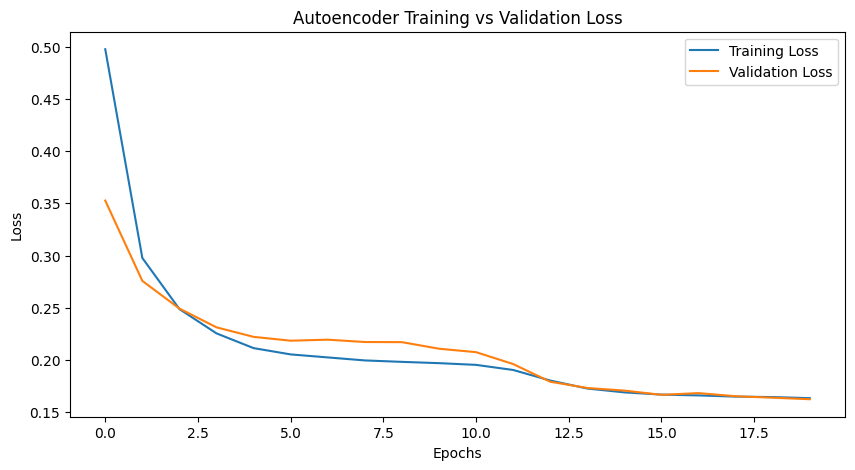

In [95]:
# ---------------------------------------------------------------
# ✅ STEP 9: SET ANOMALY THRESHOLD
# ---------------------------------------------------------------

# Use the 95th percentile of NORMAL reconstruction errors as the threshold
normal_error = error_df[error_df['True_Class'] == 0]['Reconstruction_Error']
print("Normal_error ",normal_error)
THRESHOLD = np.percentile(normal_error, 98)
print("Threshold ", THRESHOLD)
print(f"\n📊 Calculated Anomaly Detection Threshold: {THRESHOLD:.6f}")

# Predict anomalies: if reconstruction error > threshold → Fraud
error_df['Predicted_Class'] = error_df['Reconstruction_Error'] > THRESHOLD

# ---------------------------------------------------------------
# ✅ STEP 10: EVALUATE MODEL PERFORMANCE
# ---------------------------------------------------------------

# Confusion Matrix
cm = confusion_matrix(error_df['True_Class'], error_df['Predicted_Class'])
print("\nConfusion Matrix:")
print(cm)

# Precision and Recall for Fraudulent Class (1)
precision = precision_score(error_df['True_Class'], error_df['Predicted_Class'], pos_label=1)
recall = recall_score(error_df['True_Class'], error_df['Predicted_Class'], pos_label=1)

print(f"\n🔍 Precision: {precision * 100:.2f}%")
print(f"🔍 Recall:    {recall * 100:.2f}%")

# ---------------------------------------------------------------
# ✅ STEP 11: SUMMARY OF RESULTS
# ---------------------------------------------------------------

print("\n✅ MODEL EVALUATION SUMMARY")
print("------------------------------------")
print(f"Input Features: {INPUT_DIM}")
print(f"Training Samples (Normal): {X_train_normal.shape[0]}")
print(f"Validation Samples: {X_val_normal.shape[0]}")
print(f"Threshold (95th Percentile): {THRESHOLD:.6f}")
print("------------------------------------")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall:    {recall * 100:.2f}%")
print("------------------------------------")
print("✔ Model successfully detects anomalies using reconstruction error.")

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Precision: 6.97%
# Recall:    86.59%

# Precision: 6.65%
# Recall:    82.32%